In [1]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from dateutil.parser import parse

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [3]:
print(tf.__version__)

print(tf.keras.__version__)

print(pd.__version__)

2.2.0-rc4
2.3.0-tf
1.0.3


In [72]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/result.csv', encoding='cp949').set_index('date')
print(data.shape)
data.head(2)

(1501, 27)


,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,stock_KPX,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-08-01,3300.0,12000.0,17300.0,5780.0,9260.0,13700.0,20650.0,42350.0,3455.0,6380.0,3020.0,18593.0,8158.0,24381.0,28722.0,5388.0,5534.0,593.0,39369.0,1156.0,62722.0,1037.75,2073.10,677.23,676.71,631.78,2.48
2014-08-04,3300.0,12000.0,17350.0,5900.0,9280.0,13700.0,21100.0,43050.0,3465.0,6370.0,3050.0,20535.0,7925.0,32983.0,41805.0,9059.0,4286.0,600.0,41218.0,1510.0,43128.0,1033.35,2080.42,670.67,685.36,639.07,2.48


In [0]:
data.loc[str(parse(data.index[-1]).date() + timedelta(days=1))] = [np.nan for _ in range(data.shape[1])]

In [74]:
data.tail(2)

,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,stock_KPX,potato_price,tomato,green_pepper,red_pepper,cabbage,cabbage1,onion,carrot,green_onion,cucumber,Exchange_Rate,KOSPI,Dubai,Brent,WTI,시장금리
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-31,3750.0,12350.0,5400.0,9580.0,6990.0,10850.0,8800.0,3300.0,3590.0,5400.0,5300.0,53052.0,17980.0,35960.0,44016.0,7887.0,12311.0,1279.0,68390.0,844.0,43002.0,1218.8,1754.64,180.17,174.87,157.49,0.8
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
target_name = 'stock_Jobi'
target_names = [target_name,'potato_price', 'carrot']
#df = data[]
shift_steps = 1

df = data[target_names].shift(1)

df.tail(3)

,stock_Jobi,potato_price,carrot
date,,,
2020-03-30,9360.0,40648.0,63418.0
2020-03-31,9500.0,40346.0,66603.0
2020-04-01,12350.0,53052.0,68390.0


In [159]:
df_targets = df[target_name].shift(-shift_steps)
# df_targets = df.shift(-shift_steps)

df_targets.tail(3)

date
2020-03-30     9500.0
2020-03-31    12350.0
2020-04-01        NaN
Name: stock_Jobi, dtype: float64

In [160]:
df.index[-23:]

Index(['2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
       '2020-03-30', '2020-03-31', '2020-04-01'],
      dtype='object', name='date')

In [161]:
x_data = df.values[shift_steps:-23] # 3월 예측

print(type(x_data))
print("Shape:", x_data.shape)
y_data = df_targets.values[shift_steps:-23].reshape(-1,1)

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1478, 3)
<class 'numpy.ndarray'>
Shape: (1478, 1)


In [162]:
num_data = len(x_data)
print(num_data)
train_split = 0.9

num_train = int(train_split * num_data)
print(num_train)

num_test = num_data - num_train
print(num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

1478
1330
148
1478
1478


In [163]:
# input 갯수
num_x_signals = x_data.shape[1]
# output 갯수
num_y_signals = y_data.shape[1]

num_x_signals, num_y_signals

(3, 1)

In [0]:
# Scaled Data
x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
# print("Min:", np.min(x_train_scaled))
# print("Max:", np.max(x_train_scaled))

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [166]:
batch_size = 256
sequence_length = 365
warmup_steps = 100

generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 365, 3)
(256, 365, 1)


In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [170]:
optimizer = RMSprop(lr=1e-3)

model.compile(loss=loss_mse_warmup, optimizer=optimizer)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, None, 512)         794112    
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           513       
Total params: 794,625
Trainable params: 794,625
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [172]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00001: val_loss improved from inf to 0.00161, saving model to 23_checkpoint.keras
100/100 [==============================] - 24s 244ms/step - loss: 0.0145 - val_loss: 0.0016 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0028
Epoch 00002: val_loss improved from 0.00161 to 0.00060, saving model to 23_checkpoint.keras
100/100 [==============================] - 24s 243ms/step - loss: 0.0028 - val_loss: 6.0233e-04 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00003: val_loss improved from 0.00060 to 0.00043, saving model to 23_checkpoint.keras
100/100 [==============================] - 25s 246ms/step - loss: 0.0018 - val_loss: 4.2764e-04 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00004: val_loss did not improve from 0.00043

Epoch 00004: ReduceLROnPlateau reducing learn

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    signal = 0
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:, signal]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true[:, signal]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(target_names[signal])
    # plt.xlabel(np.array(dt_index.date))
    
    plt.legend()
    plt.show()

    # return signal_true, signal_pred

def pred():
  '''
    수익률 계산을 위한 실제 주식값, 예측 주식값 생성
  '''
  pred_x_data = df.values[shift_steps:-1]
  y_true = np.array(df_targets.values[shift_steps:-1], dtype=np.int)# .reshape(-1,1)

  pred_x_train_scaled = x_scaler.fit_transform(pred_x_data)
  # y_true_scaled = y_scaler.transform(y_true)

  pred_x = np.expand_dims(pred_x_train_scaled, axis=0)

  pred = model.predict(pred_x)

  pred_rescaled = y_scaler.inverse_transform(pred[0])

  pred = pred_rescaled[:, 0].astype(np.int)
  
  return y_true, pred

def returns(true, pred, term):
  '''
    수익률 계산
    계산 방법 : 
      당일 예측값 - 전일 예측값 > 0 매도
      당일 예측값 - 전일 예측값 < 0 미구매

      매도 했을 경우 실제 값의 변동의 총 합 / 주어진 기간의 실제 주식 가격 평균 * 100 (단위 : %)
  '''
  true_data = true[-term:]
  pred_data = pred[-term:]

  
  sum_true_data = true_data[1:] - true_data[:-1]
  sum_pred_data = pred_data[1:] - pred_data[:-1]

  returns = 0

  for idx, i in enumerate(sum_pred_data):
    if i > 0:
      returns += sum_true_data[idx]


  return returns / true_data.mean() * 100

In [174]:
pred()

(array([12000, 11850, 11900, ...,  9360,  9500, 12350]),
 array([18788, 15429, 14907, ..., 11955, 12051, 12105]))

In [175]:
t,p = pred()
# `20년 3월 한달간 수익률
returns(t, p, 23)

38.15365803953536

In [176]:
result_lst = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/result_lst.csv', encoding='cp949').set_index('name')

result_lst

# result_lst = pd.DataFrame(columns = ['name','error','returns']).set_index('name')

,error,returns,stock_name
name,,,
['stock_Jobi'],0.00027,48.00,stock_Jobi
"['stock_Jobi', 'tomato']",0.00029,40.97,stock_Jobi
"['stock_Jobi', 'carrot']",0.00086,40.97,stock_Jobi
"['stock_Jobi', 'onion']",0.00038,39.37,stock_Jobi
"['stock_Jobi', 'onion', 'carrot']",0.00027,37.40,stock_Jobi
"['stock_Jobi', 'potato_price', 'onion']",0.00043,37.40,stock_Jobi
"['stock_Asia', 'green_pepper', 'cabbage1', 'potato_price']",0.00025,17.63,stock_Asia
['stock_Asia'],0.00025,13.11,stock_Asia
"['stock_Asia', 'green_pepper', 'cabbage1']",0.00027,13.11,stock_Asia


In [177]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

print("loss (test-set):", result)

result_lst.loc[str([str(i) for i in df.columns])] = [round(result,5), round(returns(t, p, 23),2), target_name]
# result_lst.append([str([str(i) for i in df.columns]), (round(result,5))])
result_lst[result_lst['stock_name'] == target_name].sort_values(by = ['returns','error'], ascending=[False, True])

1/1 [==============================] - 0s 911us/step - loss: 3.1961e-04
loss (test-set): 0.00031961427885107696


,error,returns,stock_name
name,,,
['stock_Jobi'],0.00027,48.00,stock_Jobi
"['stock_Jobi', 'tomato']",0.00029,40.97,stock_Jobi
"['stock_Jobi', 'carrot']",0.00086,40.97,stock_Jobi
"['stock_Jobi', 'onion']",0.00038,39.37,stock_Jobi
"['stock_Jobi', 'potato_price', 'carrot']",0.00032,38.15,stock_Jobi
"['stock_Jobi', 'onion', 'carrot']",0.00027,37.40,stock_Jobi
"['stock_Jobi', 'potato_price', 'onion']",0.00043,37.40,stock_Jobi


In [178]:
result = result_lst.sort_values(by = ['returns','error'], ascending=[False, True])#.set_index('name')
result.to_csv('/content/gdrive/My Drive/Colab Notebooks/result_lst.csv')
result

,error,returns,stock_name
name,,,
['stock_Jobi'],0.00027,48.00,stock_Jobi
"['stock_Jobi', 'tomato']",0.00029,40.97,stock_Jobi
"['stock_Jobi', 'carrot']",0.00086,40.97,stock_Jobi
"['stock_Jobi', 'onion']",0.00038,39.37,stock_Jobi
"['stock_Jobi', 'potato_price', 'carrot']",0.00032,38.15,stock_Jobi
"['stock_Jobi', 'onion', 'carrot']",0.00027,37.40,stock_Jobi
"['stock_Jobi', 'potato_price', 'onion']",0.00043,37.40,stock_Jobi
"['stock_Asia', 'green_pepper', 'cabbage1', 'potato_price']",0.00025,17.63,stock_Asia
['stock_Asia'],0.00025,13.11,stock_Asia


In [179]:
result['stock_name'].unique()

array(['stock_Jobi', 'stock_Asia'], dtype=object)

In [180]:
result[result['stock_name'] == 'stock_Jobi']

,error,returns,stock_name
name,,,
['stock_Jobi'],0.00027,48.00,stock_Jobi
"['stock_Jobi', 'tomato']",0.00029,40.97,stock_Jobi
"['stock_Jobi', 'carrot']",0.00086,40.97,stock_Jobi
"['stock_Jobi', 'onion']",0.00038,39.37,stock_Jobi
"['stock_Jobi', 'potato_price', 'carrot']",0.00032,38.15,stock_Jobi
"['stock_Jobi', 'onion', 'carrot']",0.00027,37.40,stock_Jobi
"['stock_Jobi', 'potato_price', 'onion']",0.00043,37.40,stock_Jobi


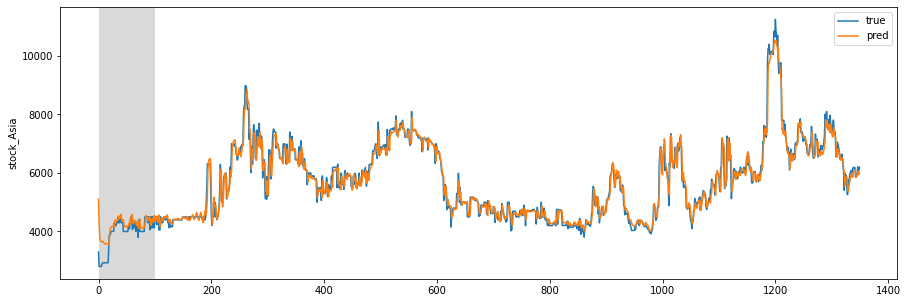

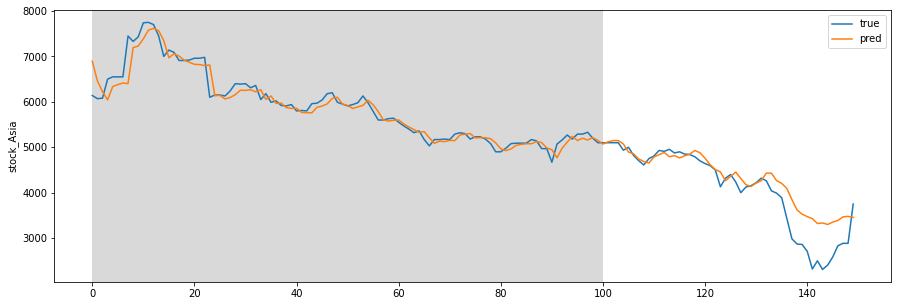

In [0]:
# stock_asia & potato & Exchange_Rate을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)

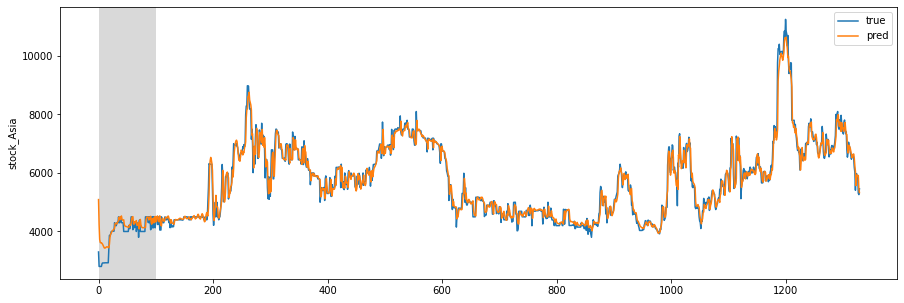

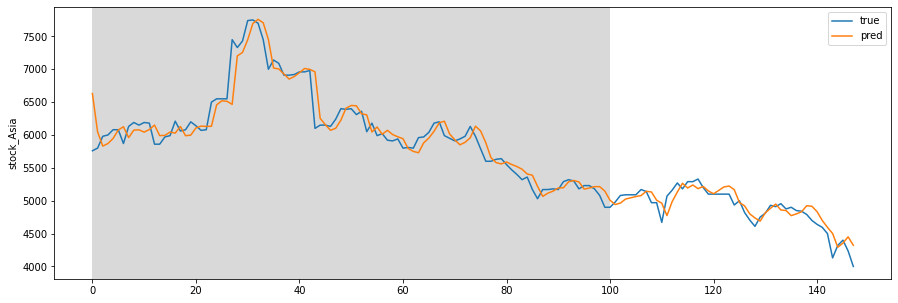

In [0]:
# stock_asia & potato을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)

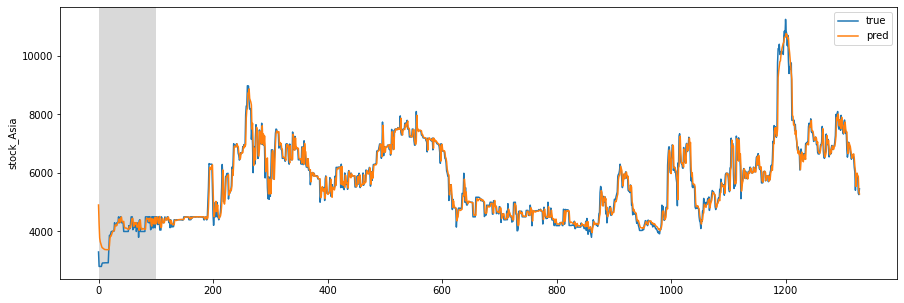

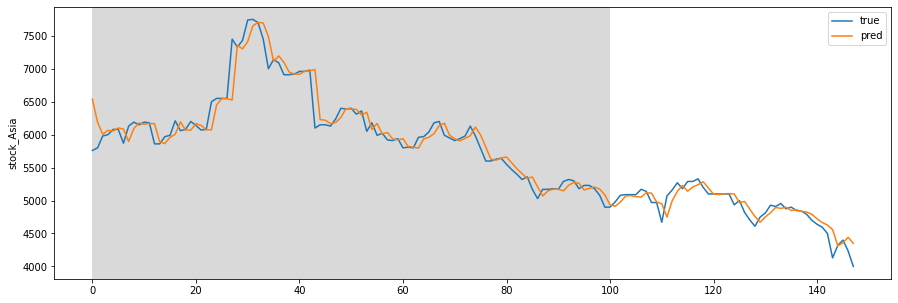

In [0]:
# stock_asia을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)